# Three-body projection code (pre-requisite for BUMPer)

This code is designed to project 3B interactions (derived from trajectories generated using Stillinger-Weber potential) onto pairwise basis sets so as to generate a composite potential with implicit three-body effects

This can be further refined using iterative force-matching

Requisities: CG.lammpstrj (using explicit three-body potentials in MD) and 1_1.dat (force-matched using simple pairwise potentials)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

In [2]:
# Kuntal Ghosh

# ============================
# Constants
# ============================

dr = 0.02
dang = 1.0
sigma_cut = 3.7
pi = 4.0 * np.arctan(1.0)
dr_rij = 0.1
nc = 6.0325587349895056

In [3]:
# ============================
# Utility functions
# ============================

def angle(v1, v2):
    dot = np.einsum("ij,ij->i", v1, v2)
    n1 = np.linalg.norm(v1, axis=1)
    n2 = np.linalg.norm(v2, axis=1)
    cos_theta = dot / (n1 * n2)
    return np.degrees(np.arccos(cos_theta))


def u_threebody(rij, rik, theta):
    lambda_ = 13.2180
    epsilon = 1.0
    coseq = -0.3875
    gamma = 1.2
    sigma = 1.0
    a = 3.71

    theta = np.radians(theta)

    term1 = np.exp((gamma * sigma) / (rij - a * sigma))
    term2 = np.exp((gamma * sigma) / (rik - a * sigma))

    u = lambda_ * epsilon * (np.cos(theta) - coseq) ** 2 * term1 * term2
    u[rik >= a] = 0.0
    return u


def simpson_coeff(n1, n2):
    sa = np.ones(n1, dtype=int)
    sb = np.ones(n2, dtype=int)

    sa[1:-1:2] = 4
    sa[2:-1:2] = 2

    sb[1:-1:2] = 4
    sb[2:-1:2] = 2

    return np.outer(sa, sb)

In [4]:
# ============================
# Read trajectory
# ============================

traj = "CG_uushort.lammpstrj"

with open(traj) as f:
    lines = f.readlines()

natoms = int(lines[3].split()[0])

box_length = np.array([float(lines[5+i].split()[1]) for i in range(3)])
volume = np.prod(box_length)

nframes = len(lines) // (natoms + 9)
rho = natoms / volume

xyz = np.zeros((nframes, natoms, 3))

idx = 0
for iframe in range(nframes):
    idx += 9
    for i in range(natoms):
        xyz[iframe, i] = list(map(float, lines[idx].split()[1:4]))
        idx += 1

In [5]:
# ============================
# Histogram setup
# ============================

angmin, angmax = 0.0, 180.0
dmin = 0.0
rij_min, rij_max = 2.4, 3.7

nbin_r = int(0.5 * box_length[0] / dr) + 1
nbin_ang = int((angmax - angmin) / dang) + 1

n1 = int((rij_max - dmin) / dr) + 1
n2 = nbin_ang

ss = simpson_coeff(n1, n2)

In [6]:
# ============================
# Main loop
# ============================

with open("u_eff.dat", "w") as fout:

    for r_fixed in np.arange(rij_min, rij_max + 1e-12, dr_rij):

        p = np.zeros((nbin_r, nbin_ang))

        for iframe in range(nframes):

            r_i = xyz[iframe][:, None, :]
            r_j = xyz[iframe][None, :, :]
            rij_vec = r_j - r_i
            rij_vec -= box_length * np.rint(rij_vec / box_length)

            rij = np.linalg.norm(rij_vec, axis=2)

            mask_rij = np.abs(rij - r_fixed) <= 0.1
            idx_i, idx_j = np.where(mask_rij)

            for i, j in zip(idx_i, idx_j):
                if i == j:
                    continue

                v1 = rij_vec[i, j]

                r_k = xyz[iframe]
                v2 = r_k - xyz[iframe, i]
                v2 -= box_length * np.rint(v2 / box_length)

                rik = np.linalg.norm(v2, axis=1)
                ang = angle(np.repeat(v1[None, :], natoms, axis=0), v2)

                valid = (
                    (rik > 1.0) &
                    (rik < 0.5 * box_length[0]) &
                    (rik < sigma_cut) &
                    (rij[i, j] < sigma_cut)
                )

                ibin_r = ((rik - dmin) / dr).astype(int)
                ibin_ang = ((ang - angmin) / dang).astype(int)

                good = (
                    valid &
                    (ibin_r >= 0) & (ibin_r < nbin_r) &
                    (ibin_ang >= 0) & (ibin_ang < nbin_ang)
                )

                np.add.at(p, (ibin_r[good], ibin_ang[good]), 1.0)

        # Normalize
        d_vals = dmin + np.arange(nbin_r) * dr
        ang_vals = angmin + np.arange(nbin_ang) * dang

        D, A = np.meshgrid(d_vals, ang_vals, indexing="ij")

        norm = (
            4.0 * pi * rho * D**2 * dr * dang *
            nframes * natoms * A
        )
        norm[A == 0.0] = 1.0
        p /= norm

        # Compute U_eff
        x1 = dmin + np.arange(n1) * dr
        x2 = angmin + np.arange(n2) * dang
        X1, X2 = np.meshgrid(x1, x2, indexing="ij")

        U = u_threebody(r_fixed, X1, X2)

        ff = p[:n1, :] * U
        pp = p[:n1, :]

        ff[0, :] = 0.0
        ff[:, 0] = 0.0
        pp[0, :] = 0.0
        pp[:, 0] = 0.0

        integ = np.sum(ss * ff) * dr * dang / 9.0
        integ_p = np.sum(ss * pp) * dr * dang / 9.0

        u_eff = 2.0 * (nc - 1.0) * integ / integ_p

        print("R and energy", r_fixed, u_eff)
        fout.write(f"{r_fixed:16.6f}{u_eff:16.6f}\n")

/tmp/ipykernel_33290/1510337664.py:9: RuntimeWarning: invalid value encountered in divide
  cos_theta = dot / (n1 * n2)
/tmp/ipykernel_33290/2967328365.py:44: RuntimeWarning: invalid value encountered in cast
  ibin_ang = ((ang - angmin) / dang).astype(int)
/tmp/ipykernel_33290/1510337664.py:10: RuntimeWarning: invalid value encountered in arccos
  return np.degrees(np.arccos(cos_theta))
/tmp/ipykernel_33290/2967328365.py:65: RuntimeWarning: invalid value encountered in divide
  p /= norm


R and energy 2.4 1.4257674909547806
R and energy 2.5 1.3733551580894963
R and energy 2.6 1.3179008081494663
R and energy 2.7 1.255700160839703
R and energy 2.8000000000000003 1.1911449686179154
R and energy 2.9000000000000004 1.1576591824396418
R and energy 3.0000000000000004 1.1680100220091216
R and energy 3.1000000000000005 1.0780913289193654
R and energy 3.2000000000000006 0.8517895558743044
R and energy 3.3000000000000007 0.5549232767369184
R and energy 3.400000000000001 0.23837333808900948
R and energy 3.500000000000001 0.04028962284351698
R and energy 3.600000000000001 0.0002399187671229862
R and energy 3.700000000000001 1.050355508199029e-51


Thus the above generated table (ueff.dat) stores the projected interactions for a given R_ij.

In [7]:
# ============================
# Parameters
# ============================

dx = 0.1
kcal_to_kj = 4.184

# ============================
# Read MSCG force file
# ============================

# File format:  d  f(d)
d, f = np.loadtxt("1_1.dat", unpack=True)
n = f.size

# ============================
# Simpson weights
# ============================

w = np.ones(n)
w[1:-1:2] = 4.0   # even j in Fortran (MOD(j,2)==0)
w[2:-1:2] = 2.0   # odd interior points

# ============================
# Vectorized Simpson integration
# u(i) = ∫_{d_i}^{d_max} f(d) dd
# ============================

# Reverse cumulative Simpson sum
u = np.cumsum((w * f)[::-1])[::-1] * dx / 3.0

# ============================
# Write output
# ============================

np.savetxt(
    "pairpot.dat",
    np.column_stack((d, u / kcal_to_kj)),
    fmt="%16.8f"
)

In [8]:
filename = 'u_eff.dat'
n_total = 66

# Read data
xi, yi = np.loadtxt(filename, unpack=True)

# Target positions for interpolation/extrapolation
x = np.linspace(2.4, 3.7, n_total)

# Spline order: 1 linear, 2 quadratic, 3 cubic
order = 1  # linear for forces, quadratic may work better for potentials

# Create spline and allow extrapolation
s = InterpolatedUnivariateSpline(xi, yi, k=order, ext=3)

# Evaluate spline at new points
y = s(x)

# ============================
# Write output
# ============================
out_file = 'ueff_extrap.dat'
with open(out_file, 'w') as f:
    for xi_val, yi_val in zip(x, y):
        f.write(f"{xi_val:16.6f}{yi_val:16.6f}\n")

In [9]:
# Treat ueff_extrap and pairpot to be separate files that will now be combined
# ueff_extrap.dat : r  u_eff
r1, ueff1 = np.loadtxt("ueff_extrap.dat", unpack=True)

# pairpot.dat : d  u_eff_pair
d, ueff2 = np.loadtxt("pairpot.dat", unpack=True)

# ============================
# Allocate total potential
# ============================

utot = np.zeros_like(ueff2)

# ============================
# Region of interest
# Fortran condition:
#   d > 2.39 .AND. d < 3.72
# ============================

roi = (d > 2.39) & (d < 3.72)

# Safety check: sizes must match
n_roi = np.count_nonzero(roi)
if n_roi != len(ueff1):
    raise ValueError(
        f"Mismatch: {n_roi=} points in ROI, but {len(ueff1)=}"
    )

In [10]:
# ============================
# Combine potentials
# ============================

# Outside ROI → pair potential only
utot[:] = ueff2[:]

# Inside ROI → add three-body correction
utot[roi] += ueff1

mask = (d >= 2.4) & (d <= 10.0)

# ============================
# Write output
# ============================

np.savetxt(
    "u_combine.dat",
    np.column_stack((d[mask], utot[mask])),
    fmt="%16.6f"
)

In [11]:
filename = 'u_combine.dat'
n_lines = len(open(filename).readlines())
n_total = 2001

# given values
xi, yi = np.loadtxt(filename, unpack=True)

# positions to inter/extrapolate
x = np.linspace(0.0, 10.0, n_total)

# spline order: 1 linear, 2 quadratic, 3 cubic ... 
order = 1 # quadratic splines work best for extrapolating pair potentials and linear splines for forces

# do inter/extrapolation
s = InterpolatedUnivariateSpline(xi, yi, k=order)
y = s(x)

out_file = open ('u_extrap.dat', 'w')

for i in range (1,n_total+1):
    out_file.write ("%16.6f%16.6f\n"%(x[i-1],y[i-1]))

In [12]:
input_file = "u_extrap.dat"
output_file = "1_1_corr.table"

# ============================
# Read input potential
# ============================

d, u = np.loadtxt(input_file, unpack=True)
nlines = len(d)

# ============================
# Compute forces (vectorized)
# f(i) = -(u(i+1) - u(i)) / dx
# ============================

f = -(u[1:] - u[:-1]) / dx  # length nlines-1

# ============================
# Write .table file
# ============================

with open(output_file, "w") as fout:
    # Header
    fout.write("# Header information on force file\n\n")
    fout.write("1_1\n")
    fout.write(f"N{nlines-1:5d}  R{d[0]:16.6f}{d[-1]:16.6f}\n\n")

    # Write table: index, d(i+1), u(i+1), f(i+1)
    indices = np.arange(1, nlines)  # 1-based indexing like Fortran
    table_data = np.column_stack((indices, d[1:], u[1:], f))
    
    # Format similar to Fortran (I5, 3F16.8)
    for row in table_data:
        fout.write(f"{int(row[0]):5d}{row[1]:16.8f}{row[2]:16.8f}{row[3]:16.8f}\n")

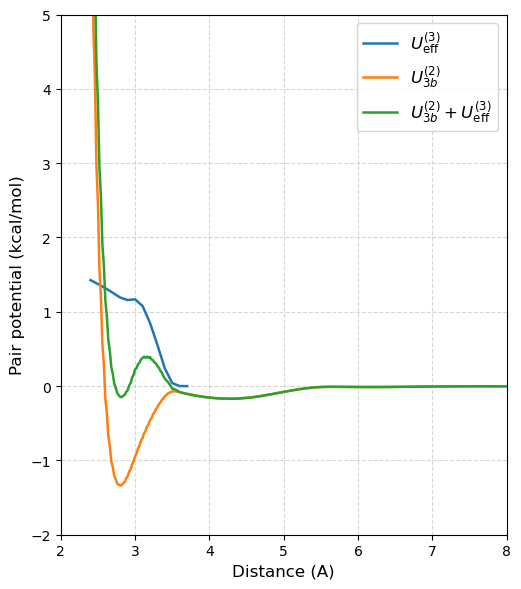

In [13]:
ueff_data = np.loadtxt("u_eff.dat")
pairpot_data = np.loadtxt("pairpot.dat")
ucombine_data = np.loadtxt("u_combine.dat")

# Columns
r_ueff, u_eff = ueff_data[:,0], ueff_data[:,1]
r_pair, u_pair = pairpot_data[:,0], pairpot_data[:,1]
r_comb, u_comb = ucombine_data[:,0], ucombine_data[:,1]

# ============================
# Plot
# ============================

plt.figure(figsize=(6,6))

plt.plot(r_ueff, u_eff, lw=1.8, label=r"$U_{\rm eff}^{(3)}$")
plt.plot(r_pair, u_pair, lw=1.8, label=r"$U_{3b}^{(2)}$")
plt.plot(r_comb, u_comb, lw=1.8, label=r"$U_{3b}^{(2)} + U_{\rm eff}^{(3)}$")

plt.xlabel("Distance (A)", fontsize=12)
plt.ylabel("Pair potential (kcal/mol)", fontsize=12)
plt.xlim(2, 8)
plt.ylim(-2, 5)
plt.gca().set_aspect('equal', adjustable='box')  # square axes
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

The green resultant curve (U_3b^2 + U_eff^3) can be directly used as a pair potential, or can be subjected to iterative force matching (to generate BUMPer).